# Linear Variational Auto Encoder
This notebook demonstrates the training of a Linear Variational Autoencoder (VAE) to learn transformations from input climate data to corresponding forced responses, with BCE loss for reconstruction.

In [ ]:
# Import necessary libraries
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import random
import warnings


from torch.utils.data import DataLoader

# Add utility paths
sys.path.append(os.path.join(os.getcwd(), 'utils'))

# Import utility functions
from utils.data_loading import *
from utils.data_processing import *
from utils.vae import *
from utils.animation import *
from utils.metrics import *
from utils.pipeline import *

# Enable autoreload
%reload_ext autoreload
%autoreload 2

# Suppress warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define data path
current_dir = os.getcwd()
data_path = os.path.join(current_dir, 'data')
print(f"Data path: {data_path}")

Data path: /Users/lharriso/Documents/GitHub/gm4cs-l/data


In [2]:
# Use MPS / Cuda or CPU if none of the options are available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
random.seed(42)

Using device: mps


In [3]:
# Load the data
filename = os.path.join(data_path, 'ssp585_time_series.pkl')
data, nan_mask = preprocess_data(data_path, filename)

Loading data from /Users/lharriso/Documents/GitHub/gm4cs-l/data/ssp585_time_series.pkl
Data loaded successfully.
Filtering data...


100%|██████████| 72/72 [00:00<00:00, 61807.18it/s]


Data filtered. Kept 34 models
Creating NaN mask...


100%|██████████| 34/34 [00:02<00:00, 16.40it/s]


NaN mask created.
Masking out NaN values...


100%|██████████| 34/34 [00:01<00:00, 26.77it/s]


NaN values masked out.
Reshaping data...


100%|██████████| 34/34 [00:04<00:00,  8.02it/s]


Data reshaped.
Adding the forced response to the data...


100%|██████████| 34/34 [00:10<00:00,  3.34it/s]


Forced response added.
Removing NaN values from the grid...


100%|██████████| 34/34 [00:01<00:00, 25.04it/s]


NaN values removed.


In [4]:
# Randomly select and keep the data corresponding to n models
n = 5
model_keys = random.sample(data.keys(), n)
data = {key: value for key,value in data.items() if key in model_keys}

/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/ipykernel_85058/3740862327.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  model_keys = random.sample(data.keys(), n)


In [5]:
# Select one of the models randomly for testing and the rest for training according to the leave-one-out strategy
test_model = random.choice(list(data.keys()))
train_models = [model for model in data.keys() if model != test_model]

# Create the training and testing datasets
train_data = {model: data[model] for model in train_models}
test_data = {test_model: data[test_model]}

print(f"Training models: {train_models}")
print(f"Testing model: {test_model}")

Training models: ['EC-Earth3', 'E3SM-2-0', 'GISS-E2-1-G', 'ACCESS-ESM1-5']
Testing model: GISS-E2-2-G


In [6]:
center = True
normalized_train_data, normalized_test_data, _, _ = normalize_data(train_data, test_data, center=center)


Normalizing data...


100%|██████████| 1/1 [00:00<00:00, 43.52it/s]

Data normalization completed.


In [7]:
# Print the distribution of the data
# Flatten the data for analysis
# flattened_data = np.concatenate([np.ravel(array) for model in normalized_train_data.values() for array in model.values()])
# print("Flattened the data")
# # Plot the distribution of the data
# plt.figure(figsize=(10, 6))
# sns.histplot(flattened_data, bins=50, kde=False)
# plt.title('Distribution of Flattened Data')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.show()

In [8]:
# # Flatten the normalized_test_data for analysis
# flattened_test_data = np.concatenate([np.ravel(array) for model in normalized_test_data.values() for array in model.values()])

# # Plot the distribution of the flattened normalized_test_data
# plt.figure(figsize=(10, 6))
# sns.histplot(flattened_test_data, bins=50, kde=False)
# plt.title('Distribution of Normalized Test Data')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.show()

In [9]:
# Create dataset for the linear VAE
train_dataset = ClimateDataset(normalized_train_data)
test_dataset = ClimateDataset(normalized_test_data)

# Create dataloaders
batch_size = 16  # Higher batch size for linear VAE
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

# Check the shape of the data
sample = next(iter(train_loader))
print(f"Input shape: {sample['input'].shape}")
print(f"Output shape: {sample['output'].shape}")

Creating datasets...


Processing models:   0%|          | 0/4 [00:00<?, ?it/s]

Processing models: 100%|██████████| 4/4 [00:00<00:00, 111107.39it/s]
/Users/lharriso/Documents/GitHub/gm4cs-l/utils/vae.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  self.inputs = torch.tensor(self.inputs, dtype=torch.float32)


Creating datasets...


Processing models: 100%|██████████| 1/1 [00:00<00:00, 35544.95it/s]

Training dataset size: 124
Testing dataset size: 11


Input shape: torch.Size([16, 165, 6523])
Output shape: torch.Size([16, 165, 6523])


In [10]:
# Initialize the Linear VAE model
# Calculate input dimension from flattened sample
sample = next(iter(train_loader))
input_shape = sample['input'].shape[1:]
print(input_shape)
input_dim = np.prod(input_shape)
print(f"Input dimension for VAE: {input_dim}")

# Set VAE parameters
hidden_dim = 256  # Increased for better representation
latent_dim = 64   # Intermediate layer size
z_dim = 2       # Actual latent space dimension
# beta = 0.001      # Weight for KL divergence term -- not used in this version

# Create the model
vae_model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, device=device).to(device)

# Apply weight initialization
# vae_model.apply(initialize_weights)

# Print model summary
print("\nLinear VAE Model Architecture:")
print(vae_model)
print(f"\nTotal parameters: {sum(p.numel() for p in vae_model.parameters() if p.requires_grad):,}")

torch.Size([165, 6523])
Input dimension for VAE: 1076295

Linear VAE Model Architecture:
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=1076295, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (mean_layer): Linear(in_features=64, out_features=5, bias=True)
  (var_layer): Linear(in_features=64, out_features=5, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=64, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [26]:
# Train the VAE
epochs = 1000
losses = []

optimizer = torch.optim.Adam(vae_model.parameters(), lr=3e-4) # Weight decay is not used in this version (was weight_decay=1e-5)


losses = train_vae(vae_model, train_loader, optimizer, epochs=epochs, device=device)

  0%|          | 1/1000 [00:03<59:33,  3.58s/it]

Epoch 1, Average Loss: 681.7832


  1%|          | 11/1000 [00:26<36:31,  2.22s/it]

Epoch 11, Average Loss: 795.0398


  2%|▏         | 21/1000 [00:47<34:33,  2.12s/it]

Epoch 21, Average Loss: 375.6909


  3%|▎         | 31/1000 [01:08<33:42,  2.09s/it]

Epoch 31, Average Loss: 421.3772


  4%|▍         | 41/1000 [01:30<35:30,  2.22s/it]

Epoch 41, Average Loss: 543.8982


  5%|▌         | 51/1000 [01:52<33:37,  2.13s/it]

Epoch 51, Average Loss: 495.2732


  6%|▌         | 61/1000 [02:13<32:43,  2.09s/it]

Epoch 61, Average Loss: 330.2140


  7%|▋         | 71/1000 [02:34<32:16,  2.09s/it]

Epoch 71, Average Loss: 745.0896


  8%|▊         | 81/1000 [02:55<31:57,  2.09s/it]

Epoch 81, Average Loss: 1363.3662


  9%|▉         | 91/1000 [03:15<31:36,  2.09s/it]

Epoch 91, Average Loss: 344.0765


 10%|█         | 101/1000 [03:36<31:14,  2.09s/it]

Epoch 101, Average Loss: 451.8519


 11%|█         | 111/1000 [03:57<30:54,  2.09s/it]

Epoch 111, Average Loss: 216.2557


 12%|█▏        | 121/1000 [04:18<30:38,  2.09s/it]

Epoch 121, Average Loss: 420.5282


 13%|█▎        | 131/1000 [04:39<30:13,  2.09s/it]

Epoch 131, Average Loss: 372.2877


 14%|█▍        | 141/1000 [05:00<29:54,  2.09s/it]

Epoch 141, Average Loss: 473.5452


 15%|█▌        | 151/1000 [05:21<29:33,  2.09s/it]

Epoch 151, Average Loss: 444.7166


 16%|█▌        | 161/1000 [05:42<29:26,  2.11s/it]

Epoch 161, Average Loss: 522.4713


 17%|█▋        | 171/1000 [06:03<28:47,  2.08s/it]

Epoch 171, Average Loss: 446.2731


 18%|█▊        | 181/1000 [06:24<28:24,  2.08s/it]

Epoch 181, Average Loss: 259.2747


 19%|█▉        | 191/1000 [06:45<28:16,  2.10s/it]

Epoch 191, Average Loss: 238.9450


 20%|██        | 201/1000 [07:05<27:51,  2.09s/it]

Epoch 201, Average Loss: 238.5025


 21%|██        | 211/1000 [07:26<27:25,  2.08s/it]

Epoch 211, Average Loss: 387.0110


 22%|██▏       | 221/1000 [07:47<27:09,  2.09s/it]

Epoch 221, Average Loss: 575.6465


 23%|██▎       | 231/1000 [08:08<26:46,  2.09s/it]

Epoch 231, Average Loss: 544.7352


 24%|██▍       | 241/1000 [08:29<26:24,  2.09s/it]

Epoch 241, Average Loss: 611.2801


 25%|██▌       | 251/1000 [08:50<26:31,  2.12s/it]

Epoch 251, Average Loss: 604.5325


 26%|██▌       | 261/1000 [09:11<25:49,  2.10s/it]

Epoch 261, Average Loss: 520.3481


 27%|██▋       | 271/1000 [09:32<25:24,  2.09s/it]

Epoch 271, Average Loss: 509.9635


 28%|██▊       | 281/1000 [09:53<24:59,  2.09s/it]

Epoch 281, Average Loss: 296.1073


 29%|██▉       | 291/1000 [10:14<24:42,  2.09s/it]

Epoch 291, Average Loss: 231.6697


 30%|███       | 301/1000 [10:35<24:17,  2.09s/it]

Epoch 301, Average Loss: 227.2755


 31%|███       | 311/1000 [10:56<23:56,  2.08s/it]

Epoch 311, Average Loss: 373.6156


 32%|███▏      | 321/1000 [11:17<23:31,  2.08s/it]

Epoch 321, Average Loss: 1252.2133


 33%|███▎      | 331/1000 [11:38<23:14,  2.09s/it]

Epoch 331, Average Loss: 559.7068


 34%|███▍      | 341/1000 [11:59<22:56,  2.09s/it]

Epoch 341, Average Loss: 226.9394


 35%|███▌      | 351/1000 [12:19<22:30,  2.08s/it]

Epoch 351, Average Loss: 477.6462


 36%|███▌      | 361/1000 [12:40<22:11,  2.08s/it]

Epoch 361, Average Loss: 229.8287


 37%|███▋      | 371/1000 [13:01<21:52,  2.09s/it]

Epoch 371, Average Loss: 195.0473


 38%|███▊      | 381/1000 [13:22<21:35,  2.09s/it]

Epoch 381, Average Loss: 213.9451


 39%|███▉      | 391/1000 [13:43<21:13,  2.09s/it]

Epoch 391, Average Loss: 260.6249


 40%|████      | 401/1000 [14:04<20:50,  2.09s/it]

Epoch 401, Average Loss: 241.7166


 41%|████      | 411/1000 [14:25<20:26,  2.08s/it]

Epoch 411, Average Loss: 287.4118


 42%|████▏     | 421/1000 [14:46<20:11,  2.09s/it]

Epoch 421, Average Loss: 170.1778


 43%|████▎     | 431/1000 [15:07<19:48,  2.09s/it]

Epoch 431, Average Loss: 284.1301


 44%|████▍     | 441/1000 [15:27<19:23,  2.08s/it]

Epoch 441, Average Loss: 482.3856


 45%|████▌     | 451/1000 [15:48<19:07,  2.09s/it]

Epoch 451, Average Loss: 362.5346


 46%|████▌     | 461/1000 [16:09<18:46,  2.09s/it]

Epoch 461, Average Loss: 617.1414


 47%|████▋     | 471/1000 [16:30<18:24,  2.09s/it]

Epoch 471, Average Loss: 152.0645


 48%|████▊     | 481/1000 [16:51<18:05,  2.09s/it]

Epoch 481, Average Loss: 588.5805


 49%|████▉     | 491/1000 [17:12<17:47,  2.10s/it]

Epoch 491, Average Loss: 77.6436


 50%|█████     | 501/1000 [17:33<17:21,  2.09s/it]

Epoch 501, Average Loss: 114.2754


 51%|█████     | 511/1000 [17:54<17:05,  2.10s/it]

Epoch 511, Average Loss: 157.5947


 52%|█████▏    | 521/1000 [18:15<17:00,  2.13s/it]

Epoch 521, Average Loss: 191.4803


 53%|█████▎    | 531/1000 [18:36<16:20,  2.09s/it]

Epoch 531, Average Loss: 145.4355


 54%|█████▍    | 541/1000 [18:57<16:06,  2.11s/it]

Epoch 541, Average Loss: 157.7696


 55%|█████▌    | 551/1000 [19:18<15:51,  2.12s/it]

Epoch 551, Average Loss: 154.6334


 56%|█████▌    | 561/1000 [19:40<15:29,  2.12s/it]

Epoch 561, Average Loss: 173.0155


 57%|█████▋    | 571/1000 [20:01<15:01,  2.10s/it]

Epoch 571, Average Loss: 172.7724


 58%|█████▊    | 581/1000 [20:22<14:36,  2.09s/it]

Epoch 581, Average Loss: 294.3285


 59%|█████▉    | 591/1000 [20:43<14:29,  2.12s/it]

Epoch 591, Average Loss: 488.3115


 60%|██████    | 601/1000 [21:04<13:54,  2.09s/it]

Epoch 601, Average Loss: 265.1624


 61%|██████    | 611/1000 [21:25<13:32,  2.09s/it]

Epoch 611, Average Loss: 184.7853


 62%|██████▏   | 621/1000 [21:48<15:25,  2.44s/it]

Epoch 621, Average Loss: 148.3225


 63%|██████▎   | 631/1000 [22:09<12:59,  2.11s/it]

Epoch 631, Average Loss: 112.1653


 64%|██████▍   | 641/1000 [22:30<12:14,  2.05s/it]

Epoch 641, Average Loss: 148.0365


 65%|██████▌   | 651/1000 [22:50<11:58,  2.06s/it]

Epoch 651, Average Loss: 136.5918


 66%|██████▌   | 661/1000 [23:11<11:34,  2.05s/it]

Epoch 661, Average Loss: 184.8348


 67%|██████▋   | 671/1000 [23:31<11:12,  2.05s/it]

Epoch 671, Average Loss: 209.6843


 68%|██████▊   | 681/1000 [23:52<10:51,  2.04s/it]

Epoch 681, Average Loss: 80.3454


 69%|██████▉   | 691/1000 [24:12<10:31,  2.04s/it]

Epoch 691, Average Loss: 120.3356


 70%|███████   | 701/1000 [24:32<10:11,  2.04s/it]

Epoch 701, Average Loss: 87.0753


 71%|███████   | 711/1000 [24:53<09:51,  2.05s/it]

Epoch 711, Average Loss: 225.2221


 72%|███████▏  | 721/1000 [25:13<09:34,  2.06s/it]

Epoch 721, Average Loss: 246.2395


 73%|███████▎  | 731/1000 [25:34<09:10,  2.05s/it]

Epoch 731, Average Loss: 130.3220


 74%|███████▍  | 741/1000 [25:54<08:48,  2.04s/it]

Epoch 741, Average Loss: 114.4141


 75%|███████▌  | 751/1000 [26:15<08:29,  2.05s/it]

Epoch 751, Average Loss: 259.6795


 76%|███████▌  | 761/1000 [26:35<08:08,  2.04s/it]

Epoch 761, Average Loss: 186.9765


 77%|███████▋  | 771/1000 [26:56<07:48,  2.05s/it]

Epoch 771, Average Loss: 323.0281


 78%|███████▊  | 781/1000 [27:16<07:27,  2.04s/it]

Epoch 781, Average Loss: 158.9525


 79%|███████▉  | 791/1000 [27:37<07:06,  2.04s/it]

Epoch 791, Average Loss: 102.3965


 80%|████████  | 801/1000 [27:57<06:48,  2.05s/it]

Epoch 801, Average Loss: 97.6330


 81%|████████  | 811/1000 [28:18<06:26,  2.04s/it]

Epoch 811, Average Loss: 710.3527


 82%|████████▏ | 821/1000 [28:38<06:06,  2.05s/it]

Epoch 821, Average Loss: 129.0543


 83%|████████▎ | 831/1000 [28:59<05:48,  2.06s/it]

Epoch 831, Average Loss: 131.6725


 84%|████████▍ | 841/1000 [29:19<05:25,  2.05s/it]

Epoch 841, Average Loss: 192.9183


 85%|████████▌ | 851/1000 [29:40<05:06,  2.06s/it]

Epoch 851, Average Loss: 162.0296


 86%|████████▌ | 861/1000 [30:00<04:46,  2.06s/it]

Epoch 861, Average Loss: 212.1481


 87%|████████▋ | 871/1000 [30:21<04:25,  2.06s/it]

Epoch 871, Average Loss: 225.1242


 88%|████████▊ | 881/1000 [30:42<04:06,  2.07s/it]

Epoch 881, Average Loss: 199.9577


 89%|████████▉ | 891/1000 [31:02<03:44,  2.06s/it]

Epoch 891, Average Loss: 95.7690


 90%|█████████ | 901/1000 [31:23<03:22,  2.05s/it]

Epoch 901, Average Loss: 517.5902


 91%|█████████ | 911/1000 [31:43<03:02,  2.05s/it]

Epoch 911, Average Loss: 102.6399


 92%|█████████▏| 921/1000 [32:04<02:41,  2.05s/it]

Epoch 921, Average Loss: 144.1261


 93%|█████████▎| 931/1000 [32:24<02:21,  2.05s/it]

Epoch 931, Average Loss: 75.1116


 94%|█████████▍| 941/1000 [32:45<02:01,  2.06s/it]

Epoch 941, Average Loss: 333.4548


 95%|█████████▌| 951/1000 [33:05<01:40,  2.05s/it]

Epoch 951, Average Loss: 86.9247


 96%|█████████▌| 961/1000 [33:26<01:20,  2.05s/it]

Epoch 961, Average Loss: 140.0546


 97%|█████████▋| 971/1000 [33:46<00:59,  2.05s/it]

Epoch 971, Average Loss: 80.1865


 98%|█████████▊| 981/1000 [34:07<00:38,  2.05s/it]

Epoch 981, Average Loss: 143.5994


 99%|█████████▉| 991/1000 [34:27<00:18,  2.05s/it]

Epoch 991, Average Loss: 97.3978


100%|██████████| 1000/1000 [34:46<00:00,  2.09s/it]


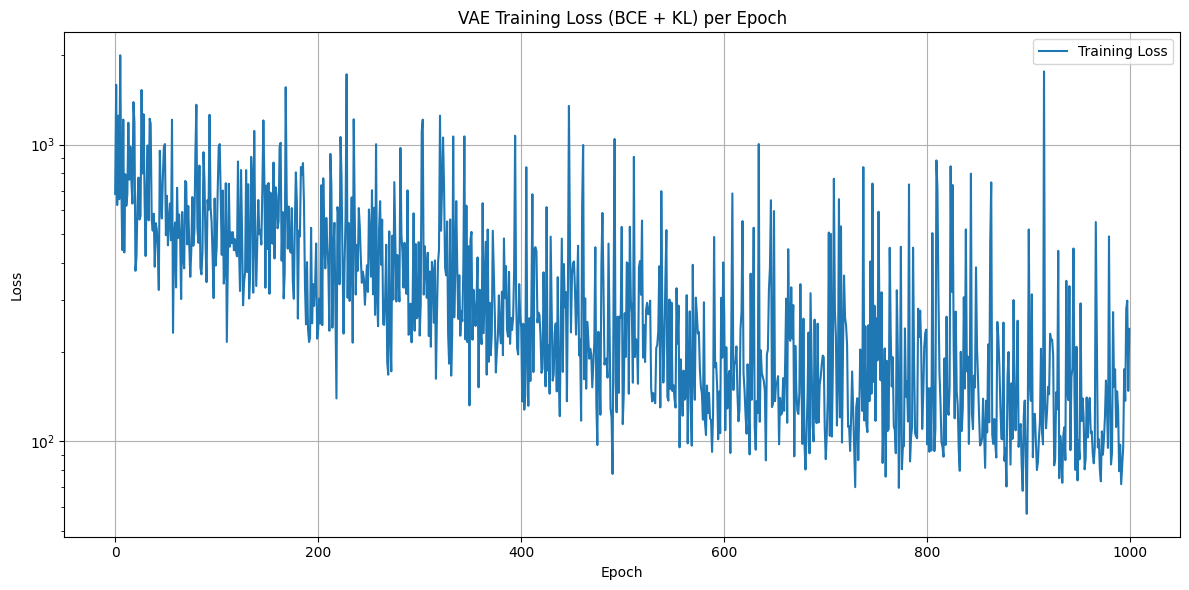

Final loss value: 239.226727


In [27]:
# Plot the training loss
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Training Loss')
plt.legend()
plt.title('VAE Training Loss (BCE + KL) per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.yscale('log')  # Using log scale to better visualize the decreasing loss
plt.tight_layout()
plt.show()

# Print the final loss value
print(f"Final loss value: {losses[-1]:.6f}")

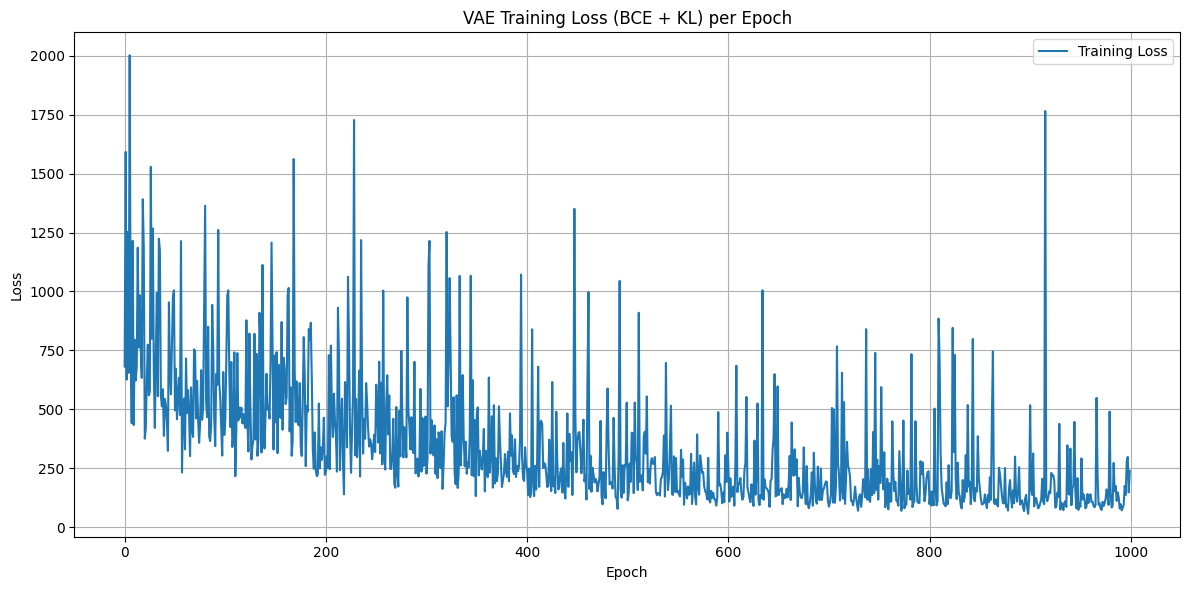

Final loss value: 239.226727


In [28]:
# Plot the training loss
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Training Loss')
plt.legend()
plt.title('VAE Training Loss (BCE + KL) per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
# plt.yscale('log')  # Using log scale to better visualize the decreasing loss
plt.tight_layout()
plt.show()

# Print the final loss value
print(f"Final loss value: {losses[-1]:.6f}")

# Random Run Selection and Inference
Now we'll select some random runs from the test model and use our trained VAE model to make predictions.

In [29]:
# Set the number of random runs to select
num_runs = 5

# Get the available runs for the test model (excluding forced_response)
test_runs = [run for run in normalized_test_data[test_model].keys() if run != 'forced_response']
print(f"Available runs for {test_model}: {test_runs}")

# Randomly select runs
if len(test_runs) > num_runs:
    selected_runs = random.sample(test_runs, num_runs)
else:
    selected_runs = test_runs
    
print(f"Selected runs for visualization: {selected_runs}")

Available runs for GISS-E2-2-G: ['r1i1p1f1', 'r1i1p3f1', 'r2i1p1f1', 'r2i1p3f1', 'r3i1p1f1', 'r3i1p3f1', 'r4i1p1f1', 'r4i1p3f1', 'r5i1p1f1', 'r5i1p3f1', 'r6i1p1f1']
Selected runs for visualization: ['r5i1p3f1', 'r1i1p1f1', 'r5i1p1f1', 'r2i1p3f1', 'r3i1p3f1']


In [30]:
# Set VAE to evaluation mode
vae_model.eval()

# Create a directory for saving animations if it doesn't exist
animation_dir = os.path.join('outputs_vae_test', 'animations', 'vae')
os.makedirs(animation_dir, exist_ok=True)
print(f"Animations will be saved to: {animation_dir}")

# Get ground truth for the test model
ground_truth = normalized_test_data[test_model]['forced_response']

# Store predictions for visualization
predictions = {}
mse_values = {}

# Generate predictions for each selected run
for run in selected_runs:
    # Get the run data
    run_data = normalized_test_data[test_model][run] # Shape 165 x 6523
    
    # Convert to torch tensor
    input_tensor = torch.tensor(run_data, dtype=torch.float32).unsqueeze(0).contiguous().view(1,-1).to(device) # Shape 1076295 = input_dim
    print(input_tensor.shape)
    
    # Make prediction with the VAE
    with torch.no_grad():
        # Forward pass through the VAE
        reconstructed, mu, log_var = vae_model(input_tensor)
        prediction = reconstructed.reshape(165, 6523).cpu().numpy()
    
    # Store prediction
    predictions[run] = prediction  # Reshape to original dimensions
    
    # Calculate MSE
    mse = np.mean((prediction - ground_truth) ** 2)
    mse_values[run] = mse
    print(f"MSE for {test_model} - {run}: {mse:.4f}")

print(f"\nAverage MSE across all selected runs: {np.mean(list(mse_values.values())):.4f}")

Animations will be saved to: outputs_vae_test/animations/vae
torch.Size([1, 1076295])
MSE for GISS-E2-2-G - r5i1p3f1: 0.0250
torch.Size([1, 1076295])
MSE for GISS-E2-2-G - r1i1p1f1: 0.0357
torch.Size([1, 1076295])
MSE for GISS-E2-2-G - r5i1p1f1: 0.0427
torch.Size([1, 1076295])
MSE for GISS-E2-2-G - r2i1p3f1: 0.0306
torch.Size([1, 1076295])
MSE for GISS-E2-2-G - r3i1p3f1: 0.0305

Average MSE across all selected runs: 0.0329


In [31]:
# Find the color limits for consistent visualization
all_data = []

# Add ground truth data
ground_truth_with_nans = readd_nans_to_grid(ground_truth, nan_mask, predictions=True)
all_data.append(ground_truth_with_nans)

# Add input data and predictions
for run in selected_runs:
    # Input data
    input_data = readd_nans_to_grid(normalized_test_data[test_model][run], nan_mask, predictions=True)
    all_data.append(input_data)
    
    # Prediction
    prediction_with_nans = readd_nans_to_grid(predictions[run], nan_mask, predictions=True)
    all_data.append(prediction_with_nans)

# Find the minimum and maximum values across all data
all_data_concatenated = np.concatenate([data.flatten() for data in all_data])
all_data_concatenated = all_data_concatenated[~np.isnan(all_data_concatenated)]
vmin, vmax = np.nanpercentile(all_data_concatenated, [2, 98])

print(f"Color limits for visualization: [{vmin:.2f}, {vmax:.2f}]")

Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Color limits for visualization: [-4.54, 0.53]


In [32]:
# Generate animations
for run in selected_runs:
    print(f"\nGenerating animations for {test_model} - {run}...")
    
    # Reshape data for animation
    input_data = readd_nans_to_grid(normalized_test_data[test_model][run], nan_mask, predictions=True)
    input_data = input_data.reshape(-1, nan_mask.shape[0], nan_mask.shape[1])
    
    prediction_data = readd_nans_to_grid(predictions[run], nan_mask, predictions=True)
    prediction_data = prediction_data.reshape(-1, nan_mask.shape[0], nan_mask.shape[1])
    
    ground_truth_data = readd_nans_to_grid(ground_truth, nan_mask, predictions=True)
    ground_truth_data = ground_truth_data.reshape(-1, nan_mask.shape[0], nan_mask.shape[1])
    
    # Create animations
    save_path = animation_dir
    
    # Input animation
    input_animation = animate_data(
        input_data,
        title=f'Input: {test_model} - {run} (MSE: {mse_values[run]:.2f})',
        interval=200,
        cmap='viridis',
        color_limits=(vmin, vmax)
    )
    display(HTML(input_animation.to_html5_video()))
    input_animation.save(f"{save_path}/vae_input_{test_model}_{run}.mp4", writer='ffmpeg', fps=15)
    
    # Prediction animation
    pred_animation = animate_data(
        prediction_data,
        title=f'VAE Prediction: {test_model} - {run} (MSE: {mse_values[run]:.2f})',
        interval=200,
        cmap='viridis',
        color_limits=(vmin, vmax)
    )
    display(HTML(pred_animation.to_html5_video()))
    pred_animation.save(f"{save_path}/vae_prediction_{test_model}_{run}.mp4", writer='ffmpeg', fps=15)
    
    # Ground truth animation (only once)
    if run == selected_runs[0]:
        gt_animation = animate_data(
            ground_truth_data,
            title=f'Ground Truth: {test_model}',
            interval=200,
            cmap='viridis',
            color_limits=(vmin, vmax)
        )
        display(HTML(gt_animation.to_html5_video()))
        gt_animation.save(f"{save_path}/vae_ground_truth_{test_model}.mp4", writer='ffmpeg', fps=15)
    
print(f"\nAll animations have been saved to {save_path}")


Generating animations for GISS-E2-2-G - r5i1p3f1...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...



Generating animations for GISS-E2-2-G - r1i1p1f1...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...



Generating animations for GISS-E2-2-G - r5i1p1f1...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...



Generating animations for GISS-E2-2-G - r2i1p3f1...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...



Generating animations for GISS-E2-2-G - r3i1p3f1...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...



All animations have been saved to outputs_vae_test/animations/vae


# Performance Analysis
Let's analyze the performance of our VAE model by comparing the MSE across different runs.

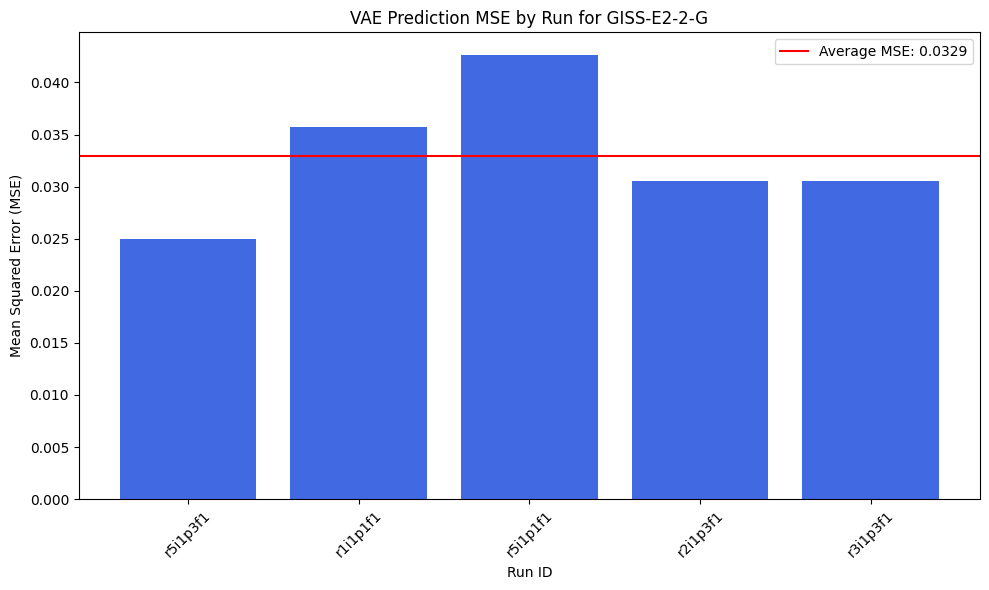

In [33]:
# Plot MSE comparison
plt.figure(figsize=(10, 6))
runs = list(mse_values.keys())
mse_vals = list(mse_values.values())

plt.bar(runs, mse_vals, color='royalblue')
plt.axhline(y=np.mean(mse_vals), color='r', linestyle='-', label=f'Average MSE: {np.mean(mse_vals):.4f}')
plt.title(f'VAE Prediction MSE by Run for {test_model}')
plt.xlabel('Run ID')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{animation_dir}/vae_mse_comparison_{test_model}.png", dpi=300, bbox_inches='tight')
plt.show()